# Improving predictive models using non-spherical Gaussian priors
Based on the CNN abstract of [Nunez-Elizalde, Huth, & Gallant](https://www2.securecms.com/CCNeuro/docs-0/5928d71e68ed3f844e8a256f.pdf).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.linalg import toeplitz
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm_notebook
%matplotlib inline

First, let's generate some data with 100 ($N$) samples and 500 ($K$) features. We'll generate the true parameters ($\beta$), for which we'll calculate the covariance matrix ($\Sigma$). 

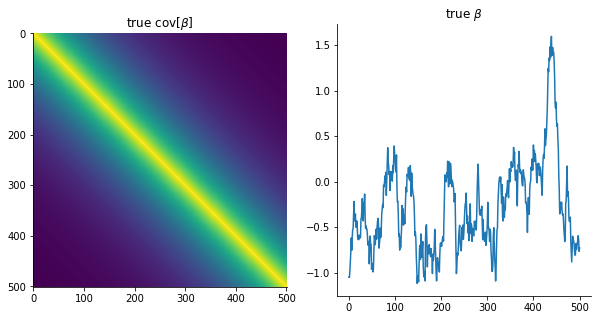

In [3]:
N, K = 100, 500
X = np.random.normal(0, 1, (N, K))
X = np.c_[np.ones(N), X]

mu_betas = np.zeros(K+1)
cov_betas = 0.99**toeplitz(np.arange(0, K+1))
betas = np.random.multivariate_normal(mu_betas, cov_betas).T

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cov_betas)
plt.title(r'$\mathrm{true\ cov}[\beta]$')

plt.subplot(1, 2, 2)
plt.plot(betas)
plt.title(r'$\mathrm{true}\ \beta$')
sns.despine()
plt.show()

noise = np.random.normal(0, 1, size=N)
y = X.dot(betas) + noise

### Standard linear regression (no regularization)

In [4]:
folds = KFold(n_splits=10)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

scores = np.zeros(10)
for i, (train_idx, test_idx) in enumerate(folds.split(X, y)):
    pipe.fit(X[train_idx], y[train_idx])
    scores[i] = pipe.score(X[test_idx], y[test_idx])

print(scores, end='\n\n')
print("R2: %3f. (%.3f)" % (scores.mean(), scores.std()))

[-0.17506196 -0.20438521  0.69783125 -0.34696657  0.36056441  0.34926236
 -0.50402675  0.05336731  0.13129403  0.30056921]

R2: 0.066245. (0.354)


### Ridge

In [5]:
folds = KFold(n_splits=10)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100, 1000]))
])

scores = np.zeros(10)
for i, (train_idx, test_idx) in enumerate(folds.split(X, y)):
    pipe.fit(X[train_idx], y[train_idx])
    preds = pipe.predict(X[test_idx])
    scores[i] = pipe.score(X[test_idx], y[test_idx])

print(scores, end='\n\n')
print("R2: %3f. (%.3f)" % (scores.mean(), scores.std()))

[-0.05012806 -0.29239414  0.50244766 -0.15503275  0.31898809  0.29825579
 -0.37950182 -0.04080342  0.13129442  0.25450183]

R2: 0.058763. (0.274)


### Tikhonov
The traditional solution for Tikhonov regression, for any design matrix $X$ and reponse vector $y$, is usually written as follows:

\begin{align}
\hat{\beta} = (X^{T}X + \lambda C^{T}C)^{-1}X^{T}y
\end{align}

in which $C$ represents the penalty matrix (i.e., $\Sigma^{-\frac{1}{2}}$)
and $\lambda$ the regularization parameter. In this formulation, the prior on the model is that $\beta$ is distributed with zero mean and $(\lambda C^{T}C)^{-1}$ covariance. Alternatively, the estimation of the parameters ($\beta$) can be written as:

\begin{align}
\hat{\beta} = C^{-1}(A^{T}A + \lambda I)^{-1}X^{T}y
\end{align}

with $A$ defined as:

\begin{align}
A = XC^{-1}
\end{align}

Let's define a scikit-learn style class for generic Tikhonov regression:

In [6]:
from scipy.linalg import sqrtm
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.linalg import svd


class Tikhonov(BaseEstimator, RegressorMixin):
    
    def __init__(self, sigma, lambd=1.):
        self.sigma = sigma
        self.lambd = lambd
        
    def fit(self, X, y, sample_weight=None):
        sig = self.sigma
        self.coef_ = np.linalg.inv(X.T @ X  + self.lambd * np.linalg.inv(sig)) @ X.T @ y
        return self

    def predict(self, X, y=None):
        return X.dot(self.coef_)
    

class Tikhonov2(BaseEstimator, RegressorMixin):
    
    def __init__(self, sigma, lambd=1.):
        self.sigma = sigma
        self.lambd = lambd
        self.C = sqrtm(self.sigma)
    
    def fit(self, X, y, sample_weight=None):
        A = X @ self.C
        I = np.eye(X.shape[1])
        self.coef_ = np.linalg.inv(A.T @ A  + self.lambd * I) @ A.T @ y
        return self

    def predict(self, X, y=None):
        A = X.dot(self.C)
        return A.dot(self.coef_)

Now, let's run our (cross-validated) Tikhonov regression:


[0.59746131 0.86305155 0.68076884 0.95328161 0.82810723 0.87237106
 0.79928693 0.88923963 0.80934824 0.85214504]

R2: 0.814506. (0.099)


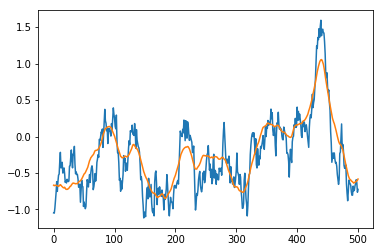

In [7]:
from sklearn.model_selection import GridSearchCV

folds = KFold(n_splits=10)
tik2 = Tikhonov(sigma=cov_betas)
gs = GridSearchCV(estimator=tik2,
                  param_grid=dict(lambd=[0.01, 0.1, 1, 10, 100]),
                  cv=3)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', gs)
])

scores = np.zeros(10)
for i, (train_idx, test_idx) in tqdm_notebook(enumerate(folds.split(X, y))):

    pipe.fit(X[train_idx], y[train_idx])
    preds = pipe.predict(X[test_idx])
    scores[i] = pipe.score(X[test_idx], y[test_idx])

print(scores, end='\n\n')
print("R2: %3f. (%.3f)" % (scores.mean(), scores.std()))

plt.plot(betas)
plt.plot(gs.best_estimator_.coef_)


[0.59746131 0.86305155 0.68076884 0.95328161 0.82810723 0.87237106
 0.79928693 0.88923963 0.80934824 0.85214504]

R2: 0.814506. (0.099)


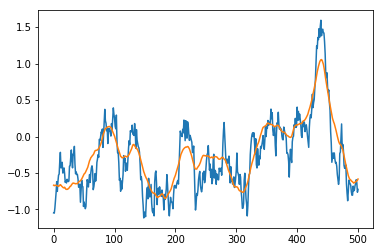

In [8]:
from sklearn.model_selection import GridSearchCV

folds = KFold(n_splits=10)
tik2 = Tikhonov2(sigma=cov_betas)
gs = GridSearchCV(estimator=tik2,
                  param_grid=dict(lambd=[0.01, 0.1, 1, 10, 100]),
                  cv=3)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', gs)
])

scores = np.zeros(10)
for i, (train_idx, test_idx) in tqdm_notebook(enumerate(folds.split(X, y))):

    pipe.fit(X[train_idx], y[train_idx])
    preds = pipe.predict(X[test_idx])
    scores[i] = pipe.score(X[test_idx], y[test_idx])

print(scores, end='\n\n')
print("R2: %3f. (%.3f)" % (scores.mean(), scores.std()))

plt.plot(betas)
plt.plot(tik2.C @ gs.best_estimator_.coef_)

## Banded ridge


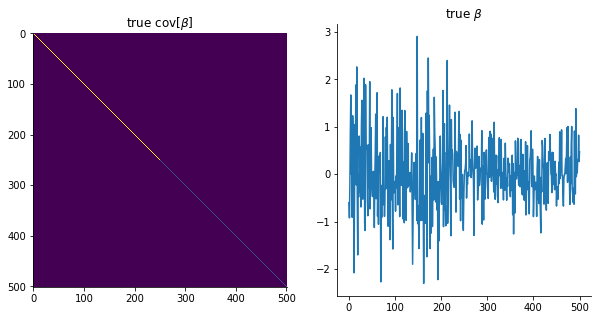

In [172]:
N, K = 200, 500
X = np.random.normal(0, 1, (N, K))
X = np.c_[np.ones(N), X]

mu_betas = np.zeros(K+1)
I = np.eye(K+1)
lambdas = np.r_[1, np.repeat([1, 2], repeats=K//2)].astype(float)
cov_betas = lambdas ** -2 * I

betas = np.random.multivariate_normal(mu_betas, cov_betas).T

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cov_betas)
plt.title(r'$\mathrm{true\ cov}[\beta]$')

plt.subplot(1, 2, 2)
plt.plot(betas)
plt.title(r'$\mathrm{true}\ \beta$')
sns.despine()
plt.show()

noise = np.random.normal(0, 1, size=N)
y = X.dot(betas) + noise

In [173]:
class BandedRidge(BaseEstimator, RegressorMixin):
    
    def __init__(self, lambd, lambdas):
        self.lambd = lambd
        self.lambdas = lambdas
        
    def fit(self, X, y, sample_weight=None):
        I = np.eye(X.shape[1])
        I[np.diag_indices_from(I)] = self.lambdas ** 2
        self.coef_ = np.linalg.inv(X.T @ X  + self.lambd * I) @ X.T @ y
        return self

    def predict(self, X, y=None):
        return X.dot(self.coef_)


[0.51164542 0.42308718 0.39207264 0.66219135 0.5068723  0.48980172
 0.26780002 0.14736223 0.56750243 0.62340932]

R2: 0.459174. (0.150)


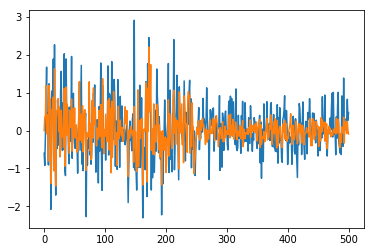

In [174]:
folds = KFold(n_splits=10)
br = BandedRidge(lambd=1, lambdas=lambdas)
gs = GridSearchCV(estimator=br,
                  param_grid=dict(lambd=[0.001, 0.01, 0.1, 1, 10, 100, 1000]),
                  cv=3)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', gs)
])

scores = np.zeros(10)
for i, (train_idx, test_idx) in tqdm_notebook(enumerate(folds.split(X, y))):

    pipe.fit(X[train_idx], y[train_idx])
    preds = pipe.predict(X[test_idx])
    scores[i] = pipe.score(X[test_idx], y[test_idx])

print(scores, end='\n\n')
print("R2: %3f. (%.3f)" % (scores.mean(), scores.std()))

plt.plot(betas)
plt.plot(gs.best_estimator_.coef_)

vs. Ridge:

[0.42749532 0.39455236 0.32529766 0.63228961 0.41289366 0.54997823
 0.1362487  0.00799585 0.52683011 0.39016874]

R2: 0.380375. (0.178)


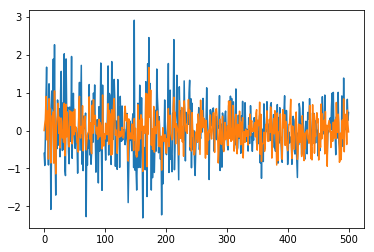

In [175]:
folds = KFold(n_splits=10)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RidgeCV(alphas=[0.01, 0.1, 1, 10, 100, 1000]))
])

scores = np.zeros(10)
for i, (train_idx, test_idx) in enumerate(folds.split(X, y)):
    pipe.fit(X[train_idx], y[train_idx])
    preds = pipe.predict(X[test_idx])
    scores[i] = pipe.score(X[test_idx], y[test_idx])

print(scores, end='\n\n')
print("R2: %3f. (%.3f)" % (scores.mean(), scores.std()))
plt.plot(betas)
plt.plot(pipe.named_steps['model'].coef_)

and standard LR:

In [176]:
folds = KFold(n_splits=10)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

scores = np.zeros(10)
for i, (train_idx, test_idx) in enumerate(folds.split(X, y)):
    pipe.fit(X[train_idx], y[train_idx])
    scores[i] = pipe.score(X[test_idx], y[test_idx])

print(scores, end='\n\n')
print("R2: %3f. (%.3f)" % (scores.mean(), scores.std()))

[0.53290474 0.39455398 0.32529149 0.61533419 0.42162928 0.5572809
 0.13712307 0.07211125 0.53426102 0.39016258]

R2: 0.398065. (0.170)


Equivalence with scaling:


[0.55909995 0.40421165 0.36377998 0.67161577 0.44084071 0.56215101
 0.21213137 0.00785866 0.53490402 0.54060681]

R2: 0.429720. (0.186)


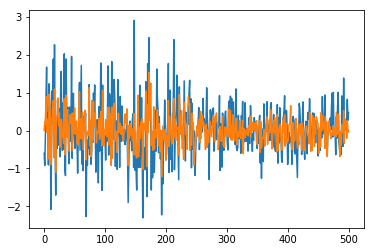

In [186]:
class BandedRidge2(BaseEstimator, RegressorMixin):
    
    def __init__(self, lambd, lambdas):
        self.lambd = lambd
        self.lambdas = lambdas
        
    def fit(self, X, y, sample_weight=None):
        I = np.eye(X.shape[1])
        X /= self.lambdas 
        self.coef_ = np.linalg.inv(X.T @ X  + self.lambd * I) @ X.T @ y
        return self

    def predict(self, X, y=None):
        return X.dot(self.coef_)
    
folds = KFold(n_splits=10)
br = BandedRidge2(lambd=1, lambdas=lambdas)
gs = GridSearchCV(estimator=br,
                  param_grid=dict(lambd=[0.001, 0.01, 0.1, 1, 10, 100, 1000]),
                  cv=3)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', gs)
])

scores = np.zeros(10)
for i, (train_idx, test_idx) in tqdm_notebook(enumerate(folds.split(X, y))):

    pipe.fit(X[train_idx], y[train_idx])
    preds = pipe.predict(X[test_idx])
    scores[i] = pipe.score(X[test_idx], y[test_idx])

print(scores, end='\n\n')
print("R2: %3f. (%.3f)" % (scores.mean(), scores.std()))

plt.plot(betas)
plt.plot(gs.best_estimator_.coef_)